# Fasting Pandas - A guide into optimizing your analytical processing 

## Lesson 1 - Conditionals

---

Welcome to Lesson 1 of "Fasting Pandas," where we'll explore how to manipulate pandas dataframes effectively using conditionals. Conditionals allow us to filter data based on certain conditions or business logic, which is a common task in data analysis. We will focus on optimizing the analytical processing of pandas dataframes. 

In this tutorial, we will highlight different techniques, including for loops, the apply method, and vectorization, to demonstrate the impact of each technique on the computational efficiency of the resulting code.

We should understand that in some ocassions suboptimal code will not cost us only time, but money aswell.

Here we go.

In [1]:
import config
import pandas as pd
import numpy as np
import fasting_pandas as fp
from statistics import mean
from matplotlib import pyplot
from IPython.display import Markdown as md

### About the Datasets

In order to avoid uploading any files to work with, we will be generating the datasets ourselves. For this tutorial I created two datasets, which can be accessed in the **datasets.py** module. The dataframes default to a size of 10,000 rows, which can be changed.

In this lesson we will work with a collection of test scores for a group of students. We have information on their ages, the amount of time they spent studying, and their scores on three different tests. Additionally, we have information on their food preferences - what they like to eat when they're feeling happy and what they prefer to eat when they're feeling sad.

Lets begin by generating the testing score dataframe.

In [2]:
df = fp.generate_testscore_df()
df.head()

,age,study_time,test_1_score,test_2_score,test_3_score,happy_food,sad_food
0,18,4,0.174730,0.181848,0.041675,pizza,beans
1,16,3,0.426864,0.469134,0.917042,hamburguer,beef-liver
2,16,6,0.987130,0.637288,0.104427,nachos,broccoli
3,12,3,0.419115,0.271577,0.282120,fried-chicken,broccoli
4,19,7,0.988256,0.330795,0.047736,nachos,tomatoes


### The Problem

For our first example we will work with data from a group of high school students between ages of 12 and 19 and their average daily time spent studying for their tests. We have the scores for 3 tests, and want to reward them with happy food if they did well.

I'll describe the dataset more throughly.

- Age: This column represents the age of each student. The values range from 12 to 19, inclusive.
- Study Time: This column represents the amount of time each student spent studying for the test, measured in hours. The values range from 0 to 10, inclusive.
- Test Scores: There are three columns in the dataset that represent the scores each student received on different tests:
    - Test 1 Score: This column represents the score each student received on the first test. The values range from 0 to 1, inclusive.
    - Test 2 Score: This column represents the score each student received on the second test. The values range from 0 to 1, inclusive.
    - Test 3 Score: This column represents the score each student received on the third test. The values range from 0 to 1, inclusive.
- Happy Food: This column represents the type of food each student prefers to eat when they're feeling happy. The possible categories are:
    + pizza
    + hamburguer
    + fried-chicken
    + nachos
    + grilled-meat
- Sad Food: This column represents the type of food each student prefers to eat when they're feeling sad. The possible categories are:
    + beef-liver
    + tomatoes
    + broccoli
    + soup
    + beans

Obviously, this is random data so don't expect too much coherence. For our purposes we don't care about this.

Let's start simple.

#### Reward calculation:
- If they studied for more than 3 hours a day and scored higher than 90 on test 1 they get happy food
- If they failed test 1 they get sad food
- If they passsed the first test (higher or equal to 65) and are in the age group between 12 and 13 they get happy food
- Everyone else gets sad food :(

So we want to define a function that uses conditional logic in order to determine who gets a positive or negative reward. One of the usual approaches is to define a function that takes care of that logic, and then check if the condition is met for every row.


In [3]:
def calculate_my_reward(row):
    if (row['study_time'] >= 4) & (row['test_1_score'] >= 0.9):
        return row['happy_food']
    elif (row['test_1_score'] >= 0.65) & (row['age'] <= 13):
        return row['happy_food']
    return row['sad_food']

## For-Loops

When it comes to iterating over rows in a Pandas DataFrame, for loops can be incredibly slow and inefficient, especially when working with larger datasets.

This is because a for loop iterates through each row of the DataFrame one at a time, performing the same operation on each row. This can be incredibly time-consuming, especially for larger datasets with hundreds of thousands or even millions of rows.

Another reason for loops can be slow is due to the Global Interpreter Lock (GIL) in Python. The GIL prevents multiple threads from executing Python code simultaneously, which means that the performance benefits of using multiple CPU cores are limited.

We can measure our results in several ways. In this first lesson we will use the `%timeit` magic method and save the results in a function that we can later access to calculate the mean() and store the results for later usage. 

In [4]:
loop_time = %timeit -o for index, row in df.iterrows(): \
        df.loc[index, 'my_reward'] = calculate_my_reward(row)

1.16 s ± 30.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


So more than a second to calculate two main conditions and a default for 10,000 rows. 

Moving on.

## Apply

If you have used pandas for more than a day, you have probably learned about the `apply` method. We can use this method to apply a custom function to each row of a DataFrame, which is often more efficient than using a for loop

The syntax is usually as follows:


 > df.apply(func, axis=0, raw=False, result_type=None, args=(), **kwds)

where ``func`` is the function to be applied, ``axis`` specifies the axis along which the function is applied (0 for column-wise, 1 for row-wise), ``raw`` specifies whether the function should receive the values or the indices of the DataFrame, and ``result_type`` specifies the expected return type of the function.

However, the ``apply`` method still has some performance overhead, as it has to create a new Series object for each row and concatenate them back into a DataFrame. Therefore, ``apply`` is not always the most efficient method for data manipulation, but it's still way faster than for loops.

Let's see how fast.

In [5]:
apply_time = %timeit -o df['my_reward'] = df.apply(calculate_my_reward, axis=1)

92.2 ms ± 1.74 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In this example, the my_reward function takes in a row of the DataFrame and returns the reward based on test scores, study time and age for that row. We then apply this function to each row of the DataFrame using the apply method with axis=1, which specifies row-wise application.

Just by using a DataFrame method we get much better results. Seems we need to learn to leverage what pandas offers to us first instead of diving into the problem head first, that is if we want our solution to scale properly (Hint: We usually do).

We calculate our percentage difference the usual way.

In [6]:
before, after = mean(loop_time.timings), mean(apply_time.timings)
result = abs((after / before) - 1)
md(f"{'{0:.0%}'.format(result)} faster. Let's go")

92% faster. Let's go

## Vectorization

Vectorization is a technique that allows performing operations on a whole array of data at once, without the need to iterate over each element. It uses NumPy arrays and functions, which are optimized for fast computation. This approach avoids the overhead of loops, and it's more efficient than using the ``apply`` method. It is also a more concise and readable way of expressing operations on arrays of data.

Using vectorization is a powerful way to transform data in pandas. It is useful in cases where we want to apply the same function to all elements of a column or a subset of a column, and the function can be written in a vectorized form.

Pandas has some vectorized methods which are:
- groupby
- filter
- transform
- Column arithmetic (+,-/*)
- .str methods
- pd.to_datetime()

We use vectorization when:
1. We want to avoid looping over the dataset
2. We want to operate on an array simultaneously
3. We can leverage numpy to push our operation into C level for-loops

Just be aware that not all operations can be vectorized, and vectorized code may require more memory than loop-based code. It's important to be aware of the limitations and benefits of vectorization and to choose the appropriate technique for each situation.

For our example we want to vectorize our logical statements. Another way of refering to this is boolean indexing. We will look at two main techniques.

### df.loc

In boolean indexing, we create a boolean mask that has the same shape as the DataFrame and use it to filter the data.

With ``df.loc``, we can select rows based on a certain condition, and it returns a new DataFrame that contains only the rows that satisfy the condition

In [7]:
def compute_with_loc():
    df['reward'] = df['sad_food'] 
    df.loc[
            (df['study_time'] >= 4) & (df['test_1_score'] >= 0.9) | 
            (df['test_1_score'] >= 0.65) & (df['age'] <= 13)
            , 'reward'
    ]  = df['happy_food']
    
loc_time = %timeit -o df['my_reward'] = compute_with_loc()

896 µs ± 6.33 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Now we are getting into nanosecond territory. Let's look at the second technique.

### numpy.where()

``numpy.where()`` is also a form of boolean indexing, but it is specifically used for creating new arrays or modifying existing ones based on a certain condition.

One of the main advantages of ``numpy.where()`` is that it avoids the need for explicit looping and thus can be faster and more memory efficient than other methods that use explicit looping. It's syntax is also cleaner.

``numpy.where()`` takes three arguments: a boolean condition, the value to be used for elements where the condition is true, and the value to be used for elements where the condition is false. It returns a new array where the elements that satisfy the condition are replaced with the first value, and the elements that do not satisfy the condition are replaced with the second value.

In [8]:
def compute_with_numpy_where():
    df['reward'] = np.where(
        (df['study_time'] >= 4) & (df['test_1_score'] >= 0.9) | (df['test_1_score'] >= 0.65) & (df['age'] <= 13), 
        df['happy_food'],
        df['sad_food']
    )

numpy_where_time = %timeit -o df['my_reward'] = compute_with_numpy_where()

650 µs ± 1.57 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [9]:
before, after = mean(loc_time.timings), mean(numpy_where_time.timings)
result = abs((after / before) - 1)
md(f"That is a {'{0:.0%}'.format(result)} performance increase by just using numpy!")

That is a 27% performance increase by just using numpy!

### .values

I'll show you one last trick. We will use the values method on each Series.

When we combine ``numpy.where()`` with the ``.values`` method, we can quickly and efficiently replace values in a DataFrame based on a certain condition. The ``numpy.where()`` method returns an array with the same shape as the input condition, where the values are set to x where the condition is True, and y where the condition is False. When we combine this with the ``.values`` method, we can assign these values directly to the DataFrame column we want to modify.

In [10]:
def compute_with_numpy_where_values():
    df['my_reward'] = np.where(
        (df['study_time'].values >= 4) & (df['test_1_score'].values >= 0.9) | (df['test_1_score'].values >= 0.65) & (df['age'].values <= 13), 
        df['happy_food'].values,
        df['sad_food'].values
    )

numpy_where_values_time = %timeit -o df['my_reward'] = compute_with_numpy_where_values()

303 µs ± 2.1 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [11]:
before, after = mean(numpy_where_time.timings), mean(numpy_where_values_time.timings)
result = abs((after / before) - 1)
md(f"Boom! Another {'{0:.0%}'.format(result)} increase!")


Boom! Another 53% increase!

By providing the values method we expose the underlying numpy array. Just the raw data, without indexes (No Series). 

## Results

Let's apply some visualization into our progress so far so we can earn our right to call this an analytics exercise.

In [12]:
timings = pd.DataFrame(
    { 'loop': loop_time.timings
    , 'apply': apply_time.timings
    , 'loc': loc_time.timings
    , 'numpy_where': numpy_where_time.timings
    , 'numpy_where_values': numpy_where_values_time.timings
    }
)

<Axes: title={'center': 'Performance improvement between techniques'}>

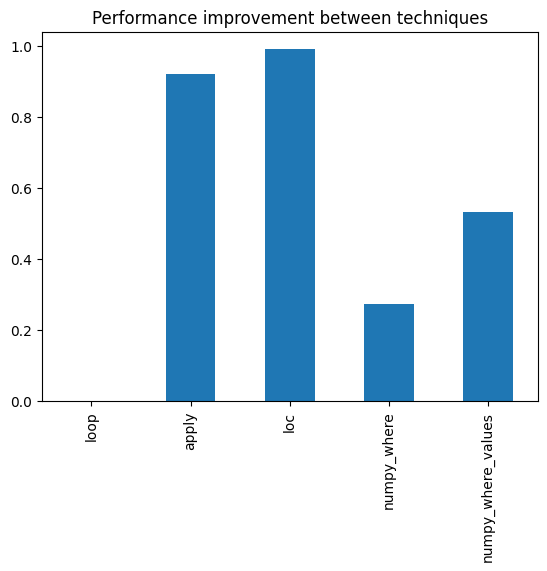

In [13]:
timings.pct_change(axis = 1).abs().mean().plot(kind = 'bar', title = 'Performance improvement between techniques')

So how fast are the vectorized functions? Well if we were to chart them we would have to use a logarithmic scale in order to appreciate it a little, since we are dealing with different magnitude levels (seconds to nanoseconds).

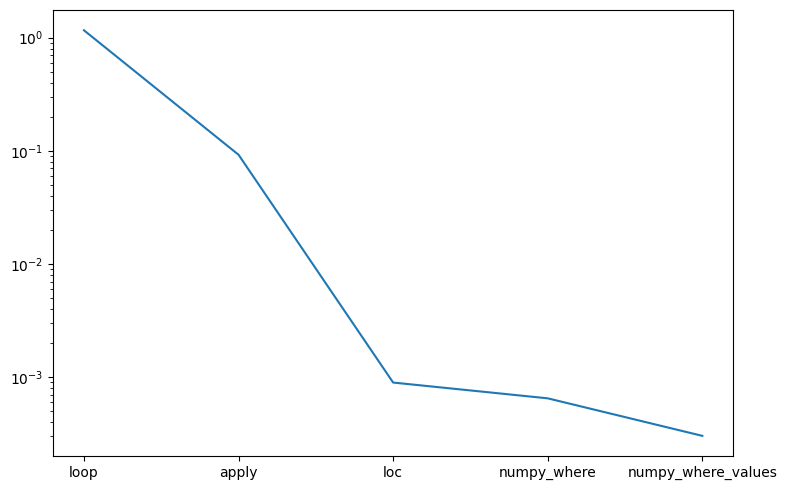

In [14]:
fig, ax = pyplot.subplots(1,1, figsize = (8,5), dpi = 100)
ax.plot(timings.mean())
ax.set_yscale('log')
fig.tight_layout()
pyplot.show()

## More Complex Conditionals

Not bad! Now, even though this is useful our problems might not be this simple. I'd dare say a more real world example would be having to apply multiple where conditions to our datasets (if..elif..elif..else..).

We would be tempted to dive right into multiple nesting using ``numpy.where()``. After all, there is something familiar about this, right? Where might have we seen this coding structure before...?

The answer is **Excel**. The pain... The horror... Instead of moving forward and improving ourselves we went back to the old ways in an instant. Why not develop a smoking habit while we are at it?

Let's say we want to classify our students based on test performance. We will classify them in 5 tiers. Failing, Barely Made It, Good, Excellent, Outstanding.

Tier Logic:
+ < 65: Failing
+ '>= 65 and <= 75: Barely Made It
+ '> 75 and <= 85: Good
+ '> 85 and <= 95: Excellent
+ '> 95: Outstanding

We will start by creating a new column called final_score where we will calculate the average of the 3 test scores. Note how we will leverage our new skills by using the ``.values`` method and combine it with the ``numpy.mean()`` vectorized function.

In [15]:
df['final_score'] = df[['test_1_score', 'test_2_score', 'test_3_score']].values.mean(axis = 1)

In [16]:
%%timeit
df['tier'] = \
    np.where(df['final_score'].values < 0.65, 'Failing',
    np.where((df['final_score'].values >= 0.65) & (df['final_score'].values <= 0.75), 'Barely Made It',
    np.where((df['final_score'].values > 0.75) & (df['final_score'].values <= 0.85), 'Good',
    np.where((df['final_score'].values > 0.85) & (df['final_score'].values <= 0.95), 'Excellent',
    'Outstanding'
))))

1.42 ms ± 30.7 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Yeah no, thanks. Even with my awesome formatting skills it feels bad, man. Add more complex logic and witness a new nightmare shape its form into your codebase. Quality Assurance will cry. Your peers will resent your presence. Your boss will begin talking about your bright future in the accounting department. Your girlfriend's boyfriend will want to meet your parents and hang out with you more frequently. All because you dared to shatter Guido's dream of a future where people learned to use python as intended. 

/rant

### numpy.select

Enter ``numpy.select()``, a more elegant solution when dealing with multiple conditionals.

``numpy.select()`` takes in a list of conditions and a list of values to be selected based on the conditions. It can handle multiple conditions and is more concise than multiple nested ``np.where()`` statements.

In [17]:
conditions = [
    df['final_score'].values < 0.65, 
    (df['final_score'].values >= 0.65) & (df['final_score'].values <= 0.75),
    (df['final_score'].values > 0.75) & (df['final_score'].values <= 0.85),
    (df['final_score'].values > 0.85) & (df['final_score'].values <= 0.95),
]

choices = [
    'Failing',
    'Barely Made It',
    'Good',
    'Excellent',
]

In [18]:
%%timeit
df['tier'] = np.select(conditions, choices, default='Outstanding')

1.12 ms ± 5.51 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Oooof. Crisis adverted. And hey, it's faster too!

## Concluding Thoughts

After analyzing the different methods for manipulating data in Pandas, we have seen that there are multiple ways to achieve the same results. However, not all methods are created equal in terms of efficiency. We have learned that using for loops and the apply method can be very inefficient, especially when working with large datasets. On the other hand, boolean indexing with df.loc and vectorization methods like numpy.where() and numpy.select() can be much faster and more efficient.

It's important to keep in mind that the choice of method depends on the specific problem and the size of the dataset. For smaller datasets, less efficient methods may be acceptable, but for larger datasets, it's essential to use more efficient techniques to avoid long processing times.

You now feel ready to refactor all your codebase and start vectorizing your functions. Cannon to right of them, Cannon to left of them, Cannon in front of them, Volleyed and thundered! But, alas, all your hopes and dreams got shut down before you could fly because your dataset is too big and froze your laptop. 

Go to [Lesson 2 - Parsing](2-parsing.ipynb)